In [1]:
from google.transit import gtfs_realtime_pb2
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import zipfile
from pathlib import Path
import py7zr
import csv

## Read in GTFS Static Data

/Users/ivo/opt/anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


stop_id      stop_name                   geometry
8116  9022001010031004      Stureplan  POINT (18.07331 59.33537)
8117  9022001010031005      Stureplan  POINT (18.07317 59.33518)
8212  9022001010102001  Norrmalmstorg  POINT (18.07333 59.33367)
8220  9022001010107001      Jarlaplan  POINT (18.06159 59.34471)
8221  9022001010107002      Jarlaplan  POINT (18.06225 59.34406)

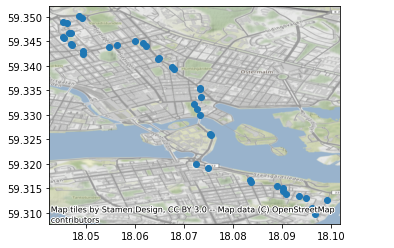

In [2]:
# Stops selected for Tvärbanan
stops = pd.read_csv('./data/2-working-data/route-2-stops.csv', index_col=0)
stops.stop_id = stops.stop_id.astype(str)

# Change to GeoDataFrame
stops['geometry'] = stops.apply(lambda x: Point(x.stop_lon, x.stop_lat), axis=1)
stops = stops.drop(columns=['location_type', 'stop_lat', 'stop_lon', 'platform_code', 'parent_station'])
stops = gpd.GeoDataFrame(stops, crs='EPSG:4326')

# Plot out and show stops
ax = stops.plot()
cx.add_basemap(ax, crs=stops.crs)

stops.head()

## Read in all TripUpdates

In [3]:
# Collect all the days in the different months
days = glob("./data/0-koda-gtfs-rt/tu/*.7z")
days[:5], len(days)

(['./data/0-koda-gtfs-rt/tu/2021-10-31.7z',
  './data/0-koda-gtfs-rt/tu/2021-12-11.7z',
  './data/0-koda-gtfs-rt/tu/2021-10-05.7z',
  './data/0-koda-gtfs-rt/tu/2021-06-18.7z',
  './data/0-koda-gtfs-rt/tu/2021-06-08.7z'],
 116)

In [4]:
days= [
    "./data/0-koda-gtfs-rt/tu/2021-10-25.7z",
    "./data/0-koda-gtfs-rt/tu/2021-10-26.7z",
    "./data/0-koda-gtfs-rt/tu/2021-10-27.7z",
    "./data/0-koda-gtfs-rt/tu/2021-10-28.7z",
    "./data/0-koda-gtfs-rt/tu/2021-10-29.7z"
]

In [5]:
!mkdir ./data/10-cleaned-data-camille/

mkdir: ./data/10-cleaned-data-camille/: File exists


In [6]:
iterator = tqdm(days)
for day in iterator:

    path = day.split('/')[4]
    out = f"""TU-{path[:4]}{path[5:7]}{path[8:10]}"""
    out_path = f"""./data/10-cleaned-data-camille/{out}.csv"""
    
    if os.path.exists(out_path):
        print(out+" exists.")
        continue
    
    with py7zr.SevenZipFile(day, 'r') as archive:
        allfiles = archive.getnames()
        targets = [f for f in allfiles if f.endswith('.pb')]
        iterator.set_description(f"""{out}: Unpacking {len(targets)} files""")
        files = archive.read(targets)

    iterator.set_description(f"""{out}: Reading""")
    tu_data = []
    for target in tqdm(targets, leave=False):

        feed = gtfs_realtime_pb2.FeedMessage()
        feed.ParseFromString(files[target].read())

        for e in feed.entity: 
            tu_data += [
                (e.trip_update.timestamp, 
                 e.trip_update.trip.trip_id,
                 e.trip_update.trip.schedule_relationship,
                 stop_update.stop_id,
                 stop_update.arrival.time, 
                 stop_update.arrival.delay, 
                 stop_update.departure.time,
                 stop_update.departure.delay)
                for stop_update in e.trip_update.stop_time_update
                if stop_update.stop_id in stops.stop_id.to_list()
        ]
    
    iterator.set_description(f"""{out}: Writing CSV with {len(tu_data)} lines""")
    # Incorporate collected data into DataFrame.
    tu_df = pd.DataFrame(tu_data, columns=['timestamp', 'trip_id', 'rel', 'stop_id', 
                                        'arrival_ts', 'arrival_delay', 
                                        'departure_ts', 'departure_delay'])

    tu_df.to_csv(out_path)
    
    del tu_df
    del tu_data

  0%|          | 0/5 [00:00<?, ?it/s]

TU-20211025 exists.
TU-20211026 exists.
TU-20211027 exists.
TU-20211028 exists.
TU-20211029 exists.
